In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [2]:
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

In [3]:
def read_map(plate_map):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['H']), 'suffix'] = (plate_map['variable'] - 1) % 12
    plate_map.loc[plate_map['group'].isin(['H']), 'suffix'] = (plate_map['variable'] - 1) % 2
    return plate_map[['Well', 'value', 'suffix']]

def generate_metadata(well, plate_map, sample_map):
    
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(int).astype(str)
    return df.dropna()

def transpose_data(df, col, timepoint=20):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index(drop=True)
    df.index = df.index * timepoint
    return df

def generate_data(df, name, datapoint=2, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(idxs[i-1] + datapoint)
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1).reset_index(drop=True)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    data = blank_corr_fluo / blank_corr_od
    neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)

In [4]:
def generate_responses(data, promoters, inducers):
    
    df_res = pd.DataFrame([data[data.index.str.startswith(promoter)].values for promoter in promoters]).T
    df_res.columns = promoters
    df_ind = pd.DataFrame(inducers).T
    df_ind.columns = promoters
    return df_res, df_ind

def plot_responses(row, col, datas, inducers, promoters, labels, colors, sharex=True, sharey=False, log_scale=False):
    
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*5, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            for j, data in enumerate(datas):
                #print(i, j, data.shape)
                response = data[data.index.str.startswith(promoters[i])].values
                ax.scatter(inducers[i], response, color=colors[j], label=labels[j])
                if log_scale:
                    ax.loglog()
                    #ax.scatter(np.log(inducers[i]), np.log(response), color=colors[j], label=labels[j])
                #else:
                #    ax.scatter(inducers[i], response, color=colors[j], label=labels[j])
            ax.set_title('{}'.format(promoters[i]))
            ax.legend()
        else:
            ax.set_visible(False)
    
    sns.despine()
    plt.tight_layout()

In [11]:
sample_map = {
    'P62': 'PBAD-rJ/Ara',
    'P63': 'AraC-pBAD-rJ/Ara',
    'P64': 'PCin-rJ/OHC14',
    'P65': 'PCymRC-rJ/Cuma',
    'P66': 'CymRC-PCymRC-rJ/Cuma',
    'P67': 'PLux2-rJ/AHL',
    'P68': 'PLuxB-rJ/AHL',
    'P69': 'PPhlF-rJ/DAPG',
    'P70': 'PSalTTC-rJ/Sal',
    'P71': 'PVanCC-rJ/Van',
    'P72': 'RhaS-PRhaB-rJ/Rha',
    'P73': 'AraC-PBAD/Ara',
    'P66.1': 'CymRC-PCymRC-rJ.1/Cuma',
    'P86': 'PBetI-rJ/Cho',
    'P87': 'PTac-rJ/IPTG',
    'P88': 'PTet-rJ/aTc',
    'P89': 'PTtg-rJ/Nar',
    'BK': 'blank-kan',
    'BA': 'blank-amp',
    '3K3-N': 'negative-control-kan',
    '4A3-N': 'negative-control-amp',
    '4A3-P': 'positive-control-amp'
}

def read_data(folder, filename, plate_map):
    
    plate_map = read_map(plate_map)
    raw_data = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, filename), skiprows=[0])
    metadata = generate_metadata(raw_data['Well'], plate_map, sample_map)
    data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
    return generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))

def get_data_at(fluos, ods, h=6):
    
    samples = get_neg_ctrl_corrected(fluos[filter(lambda x: '-amp' not in x, fluos.columns)],
                                 ods[filter(lambda x: '-amp' not in x, ods.columns)])
    reporter = get_neg_ctrl_corrected(fluos[filter(lambda x: '-amp' in x, fluos.columns)],
                                      ods[filter(lambda x: '-amp' in x, ods.columns)])
    return samples.iloc[int(h * 60/20)].apply(lambda x:  x / reporter.iloc[int(h * 60/20)].mean())

In [6]:
folder = '200-JW-promoters-characterization'

map_name = '01-02-plate_map'
plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [52, 52, 52, 200, 200, 15300] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []
for x, mi in enumerate(max_inducers):
    dil = 4 if x < 3 else 2
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    #inducer[0] = 0
    inducers.append(inducer)

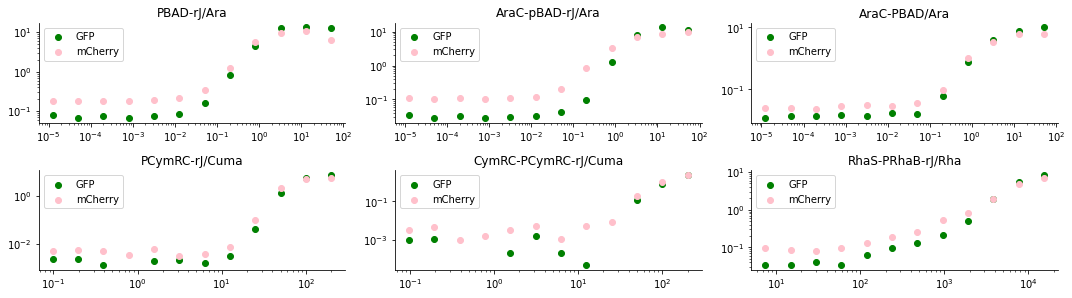

In [7]:
filename = 'JW-promoter-characterization-01-repeat'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
df_gfp = get_data_at(fluos_2_gfp, ods_gfp, h=12)
#df_res_gfp, df_ind_gfp = generate_responses(df_gfp, promoters, inducers)
#plot_responses(3, 3, df_gfp, inducers, promoters, sharex=False, log_scale=True)

filename = 'JW-promoter-characterization-02-repeat'
ods_mc, fluos_mc, fluos_1_mc, fluos_2_mc = read_data(folder, filename, plate_map)
df_mc = get_data_at(fluos_2_mc, ods_mc, h=12)
#df_res, df_ind = generate_responses(df, promoters, inducers)
#plot_responses(3, 3, df, inducers, promoters, sharex=False, log_scale=True)

labels = ['GFP', 'mCherry']
colors = ['green', 'pink']
plot_responses(3, 3, [df_gfp, df_mc], inducers, promoters, labels, colors, sharex=False, log_scale=True)

In [8]:
map_name = '03-04-plate_map'

plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [120, 40, 40, 500, 1600, 2000]
inducers = []
for x, mi in enumerate(max_inducers):
    dil = 4 if x==1 or x==2 else 2
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    #inducer[0] = 0
    inducers.append(inducer)

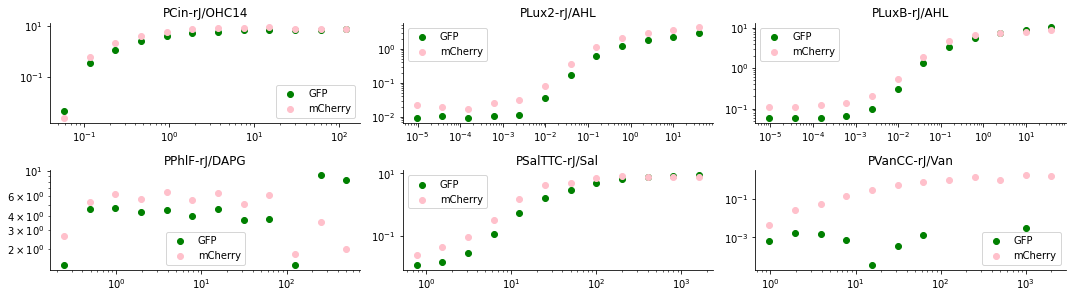

In [9]:
filename = 'JW-promoter-characterization-03'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
df_gfp = get_data_at(fluos_2_gfp, ods_gfp, h=9)

filename = 'JW-promoter-characterization-04'
ods_mc, fluos_mc, fluos_1_mc, fluos_2_mc = read_data(folder, filename, plate_map)
df_mc = get_data_at(fluos_2_mc, ods_mc, h=9)

labels = ['GFP', 'mCherry']
colors = ['green', 'pink']
plot_responses(3, 3, [df_gfp, df_mc], inducers, promoters, labels, colors, sharex=False, log_scale=True)

In [12]:
map_name = '05-06-plate_map'

plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [20000, 2000, 2, 2000, 2000, 2000]
inducers = []
for x, mi in enumerate(max_inducers):
    dil = 2
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    #inducer[0] = 0
    inducers.append(inducer)

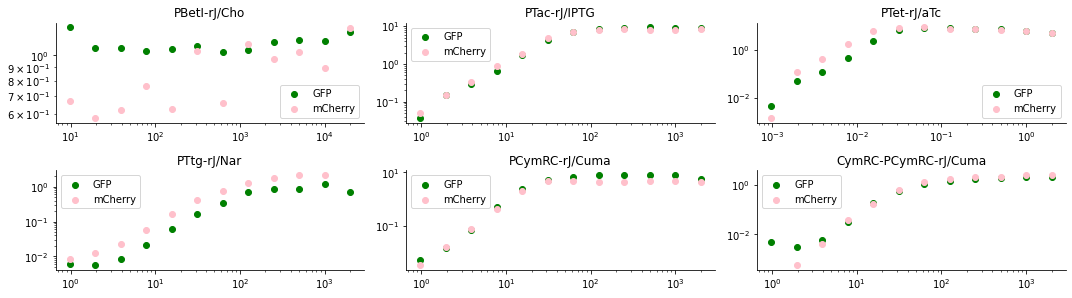

In [13]:
filename = 'JW-promoter-characterization-05'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
df_gfp = get_data_at(fluos_2_gfp, ods_gfp, h=9)

filename = 'JW-promoter-characterization-06'
ods_mc, fluos_mc, fluos_1_mc, fluos_2_mc = read_data(folder, filename, plate_map)
df_mc = get_data_at(fluos_2_mc, ods_mc, h=9)

labels = ['GFP', 'mCherry']
colors = ['green', 'pink']
plot_responses(3, 3, [df_gfp, df_mc], inducers, promoters, labels, colors, sharex=False, log_scale=True)

In [ ]:
folder = '106-promoters-characterization'

map_name = '006-plate_map'
plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [416, 160, 800, 20, 50, 1600, 15300] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []

dil = 2
for x, mi in enumerate(max_inducers):
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

In [ ]:
gfps = []

filename = '006-promoters-characterization-01'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=12))

filename = '008-promoters-characterization-02'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=12))

filename = '010-promoters-characterization-03'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=12))

labels = ['1', '2', '3']
colors = ['red', 'green', 'blue']
plot_responses(3, 3, gfps, inducers, promoters, labels, colors, sharex=False, log_scale=True)

In [ ]:
map_name = '029-plate_map'
plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [52, 52, 200, 40, 50, 15300, 52]
inducers = []

for x, mi in enumerate(max_inducers):
    dil = 2 if x in [2, 4, 5] else 4
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

In [ ]:
gfps = []
h = 10
filename = '029-promoters-characterization-06'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=h))

labels = ['1', '2', '3']
colors = ['red', 'green', 'blue']
plot_responses(3, 3, gfps, inducers, promoters, labels, colors, sharex=False, log_scale=True)

In [ ]:
map_name = '030-plate_map'
plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [52, 52, 52, 200, 200, 40, 52]
inducers = []

for x, mi in enumerate(max_inducers):
    dil = 2 if x in [3, 4, 6] else 4
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

In [ ]:
gfps = []
h = 10

filename = '030-promoters-characterization-07'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=h))

filename = '031-promoters-characterization-08'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=h))

labels = ['1', '2', '3']
colors = ['red', 'green', 'blue']
plot_responses(3, 3, gfps, inducers, promoters, labels, colors, sharex=False, log_scale=True)

In [ ]:
map_name = '034-plate_map'
plate_map = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, map_name))
promoters = [sample_map[p] for p in plate_map['1'].dropna().tolist() if p.startswith('P')]

induction_lvl = 11
max_inducers = [40, 50, 1600, 15300, 52, 200]
inducers = []

for x, mi in enumerate(max_inducers):
    dil = 2 if x not in [0, 4] else 4
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

In [ ]:
gfps = []
h = 12

filename = '034-promoters-characterization-rep1-20220313'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=h))

filename = '035-promoters-characterization-rep2-20220314'
ods_gfp, fluos_gfp, fluos_1_gfp, fluos_2_gfp = read_data(folder, filename, plate_map)
gfps.append(get_data_at(fluos_2_gfp, ods_gfp, h=h))

labels = ['1', '2', '3']
colors = ['red', 'green', 'blue']
plot_responses(3, 3, gfps, inducers, promoters, labels, colors, sharex=False, log_scale=True)